### Exploring data augmentation and classic image segmentation methods
### Ming Ong
### Kaustubh Illindala

#### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import re
import random
# being lazy copied this from the random forest workbench
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


#### Set paths for images, assumes segmentation folder is in same directory

In [2]:
folder_dir = 'USA_segmentation'
masks_dir = 'masks'
nrg_dir = 'NRG_images'
rgb_dir = 'RGB_images'
pwd = Path('.')
rgb_images_dir = pwd / folder_dir / rgb_dir
nrg_images_dir = pwd / folder_dir / nrg_dir
mask_images_dir = pwd / folder_dir / masks_dir


#### Select a random image and plot its RGB/NRG/mask side-by-side

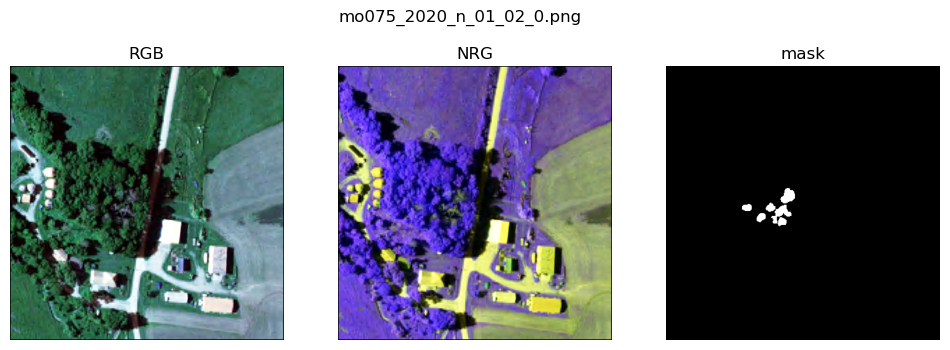

In [3]:
filename = str(random.sample(list(rgb_images_dir.iterdir()), 1)[0])
match = re.search(r'[^\/]*$', filename)
if match:
    rgb_filename = match.group(0)
    match2 = re.search(r'(?:^[^_]*_)(.*)', rgb_filename)
    if match2:
        base_filename = match2.group(1)
        nrg_filename = 'NRG_' + base_filename
        mask_filename = 'mask_' + base_filename
        # print(mask_filename, nrg_filename, rgb_filename, sep='\n')

        rgb_image = cv2.imread(str(rgb_images_dir/rgb_filename))
        nrg_image = cv2.imread(str(nrg_images_dir/nrg_filename))
        mask_image = cv2.imread(str(mask_images_dir/mask_filename))

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        fig.suptitle(base_filename)

        axes[0].imshow(rgb_image)
        axes[0].axis('off')
        axes[0].set_title('RGB')

        axes[1].imshow(nrg_image)
        axes[1].axis('off')
        axes[1].set_title('NRG')

        axes[2].set_title('mask')
        axes[2].imshow(mask_image)
        axes[2].axis('off')

        # fig.tight_layout()

#### implementing a basic image segmentation


In [4]:
def thresholdImg(image, tNum):
    cv2.threshhold(image,tNum,255, cv2.THRESH_TOZERO_INV)

73.51162790697674


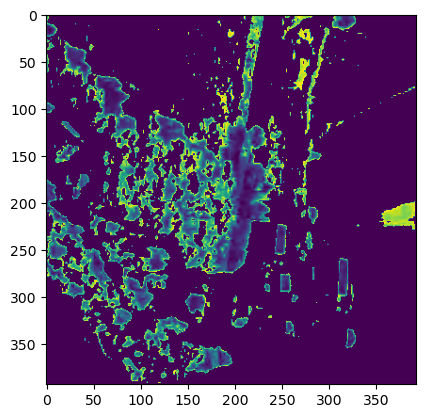

In [5]:
rgb = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
mask = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
locs = np.where(mask == 255)

nrg = cv2.cvtColor(nrg_image, cv2.COLOR_BGR2GRAY)
pixels = nrg[locs]
ret2,th2 = cv2.threshold(nrg,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)
plt.imshow(th2)
print(np.mean(pixels))

how we can implement:
use feature analysis to select features, (preferable in a kernel and then use ml to analyse if kernel contains dead trees. alternatively could train on every pixel (would be more accurate but very bad timewise

In [35]:
def perfSift(image, n=20):
    sift = cv2.SIFT_create(n);
#     gry = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return  sift.detect(image,None)

In [36]:
def getKernel(point, image, mask):
    kn = np.ones((5,5))
    res = 0
    for i in range(-2,3):
        for j in range(-2,3):
            x = int(point.pt[0])+i
#             print(x)
            y = int(point.pt[1])+j
            if(x < 0 or y < 0 or x>=image.shape[0] or y>=image.shape[1]):
                kn[i][j] = image[point.pt[0],point.pt[1]]
                continue
            if (mask[x][y]!=0):
                res = 1
            kn[i][j] = image[x][y]
    return (kn,res)

In [50]:
def analyseImage(image, mask, n=20):
    print("testImage")
    data = np.zeros((n,5,5))
    info = np.zeros(n)
    kp = perfSift(image,n)
    i = 0
    for point in kp:
        res = getKernel(point, image, mask)
        data[i] = res[0]
        info[i] = res[1]
        i+=1
#       ugh i knowwwww
#im so annoyed sift seems to always pick areas where theres no mask
    return (data, info)
        

In [ ]:
print(analyseImage(rgb,mask,1000))
X, y = analyseImage(rgb,mask,400)
#because i dont want to implement the algorithm that gets all the images yet

In [43]:
def trainRandomFor(Xdat,yDat):
    rf = RandomForestClassifier()
    return rf.fit(Xdat,yDat)

hello


In [ ]:
def testRandomFor(rf, Xdat, yDat):
    y_pred = rf.predict(Xdat)
    accuracy = accuracy_score(yDat, y_pred)
    print("Accuracy:", accuracy)
#     borrowed with some credit from www.datacamp.com/tutorial/random-forests-classifier-python





In [ ]:
def RunTest(imageList, maskList, n = 50):
#     please god let someone else have implemented a better image file reader
    i = imageList.len()
    res = analyseImage(imageList[0],maskList[0],n)
    Xdat = res[0]
    ydat= res[1]
    for index in range i:
        if(index ==0):
            continue
        res = analyseImage(imageList[index], maskList[index],n)
        Xdat = np.concatenate(Xdat, res[0])
        ydat = np.concatenate(ydat, res[1])
    X_train, X_test, y_train, y_test = train_test_split(Xdat, ydat, test_size=0.2)
    rf = trainRandomFor(X_train, y_train)
    testRandomfor(rf, X_test, y_test)